## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
from datasets import load_from_disk
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score
from collections import Counter, defaultdict
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification 
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from datasets import load_metric, concatenate_datasets, load_from_disk
from collections import Counter, defaultdict
import seaborn as sns
from matplotlib import pyplot as plt

/home/eli/envs/bt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

In [2]:
model_name = 'dbmdz/bert-base-german-uncased'

In [3]:
date_of_experiment = '2022_07_10'

## Tokenizer

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name) # more params defined in method tokenize_and_align_labels()

## Data collator

In [5]:
data_collator = DataCollatorForTokenClassification(tokenizer)

## Training params

In [7]:
NUM_EPOCHS = 10
BATCH_SIZE = 4
LOGGING_STRATEGY='epoch'
OUTPUT_DIR = f'../../../../../models/{model_name}-sm_tg_combined-{NUM_EPOCHS}_epochs_{date_of_experiment}'
OVERWRITE_OUTPUT_DIR = True
LOG_LEVEL = 'error'
EVALUATION_STRATEGY = 'epoch'
SAVE_STRATEGY ='epoch'
WEIGHT_DECAY = 0.01 # The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.
CALLBACK = EarlyStoppingCallback(early_stopping_patience=3)
LOAD_BEST_MODEL_AT_END = True,
METRIC_FOR_BEST_MODEL='eval_loss'

## Check GPU and set up torch device

In [8]:
# check gpu
torch.cuda.is_available()

True

In [9]:
# create torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and prepare data

### Combine Smartdata and Telegram train splits to create training data

In [10]:
smartdata = load_from_disk('/home/eli/data/data_prepared_for_tf/smartdata/')
telegram = load_from_disk('/home/eli/data/data_prepared_for_tf/telegram_train_test_valid/')
assert smartdata['train'].features == telegram['train'].features
assert smartdata['test'].features == telegram['test'].features
assert smartdata['validation'].features == telegram['validation'].features

In [11]:
assert smartdata['validation'].features == telegram['validation'].features

In [12]:
telegram['validation'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=13, names=['O', 'B-DATE', 'I-DATE', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-TIME', 'I-TIME', 'B-ACTION', 'I-ACTION'], id=None), length=-1, id=None),
 'ner_tags_str': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [13]:
train_ds = concatenate_datasets([smartdata['train'], telegram['train']])

### Shuffle training data

In [14]:
train_ds = train_ds.shuffle(seed=42)

Loading cached shuffled indices for dataset at /home/eli/data/data_prepared_for_tf/smartdata/train/cache-f2fd20590db54290.arrow


### Combine Smartdata and Telegram test splits as validation set

In [15]:
telegram['validation'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=13, names=['O', 'B-DATE', 'I-DATE', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-TIME', 'I-TIME', 'B-ACTION', 'I-ACTION'], id=None), length=-1, id=None),
 'ner_tags_str': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [16]:
smartdata['validation'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=13, names=['O', 'B-DATE', 'I-DATE', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-TIME', 'I-TIME', 'B-ACTION', 'I-ACTION'], id=None), length=-1, id=None),
 'ner_tags_str': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [17]:
eval_ds = concatenate_datasets([smartdata['validation'], telegram['validation']])

### Methods for processing

In [18]:
def get_indices_and_tags(ds, tag_name='ner_tags'):
    tags = ds.features[tag_name].feature
    #id2label param for model
    index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
    # label2id param for model
    tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
    
    return tags, index2tag, tag2index


def tokenize_and_align_labels(examples):
    
    tokenized_inputs = tokenizer(
        examples['tokens'], 
        padding='max_length',
        truncation=True, 
        is_split_into_words=True
    )    
    
    labels = []
    
    for idx, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else: 
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs


def encode_dataset(corpus, columns_to_remove=['ner_tags', 'tokens', 'ner_tags_str']):
    return corpus.map(tokenize_and_align_labels, 
                      batched=True,
                      remove_columns=columns_to_remove)

### Methods for evaluation

In [19]:
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        labels_list.append(example_labels)
        preds_list.append(example_preds)
        
    return preds_list, labels_list    


def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    return {'f1': f1, 
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy}


def get_training_history(trainer):
    df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_accuracy']]
    df = df.rename(columns={"epoch":"epoch",
                            "loss": "training_loss", 
                            "eval_loss": "validation_loss", 
                            "eval_f1":"f1", 
                            "eval_precision": "precision",
                           'eval_recall': 'recall', 
                            'eval_accuracy': 'accuracy'})
    df['epoch'] = df["epoch"].apply(lambda x: round(x))
    df['training_loss'] = df["training_loss"].ffill()
    df[['validation_loss', 'f1']] = df[['validation_loss', 'f1']].bfill().ffill()
    df.drop_duplicates()
    
    return df

In [20]:
tags, index2tag, tag2index = get_indices_and_tags(train_ds)

In [21]:
train_encoded = encode_dataset(train_ds)

Parameter 'function'=<function tokenize_and_align_labels at 0x7f08633bb940> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.64ba/s]


In [22]:
eval_encoded = encode_dataset(eval_ds)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.62ba/s]


## model initialization and config

In [23]:
model_config = AutoConfig.from_pretrained(model_name, 
                                        num_labels=tags.num_classes, 
                                        id2label=index2tag,
                                        label2id=tag2index)

In [24]:
model = AutoModelForTokenClassification.from_pretrained(model_name, config=model_config).to(device)

Some weights of the model checkpoint at dbmdz/bert-base-german-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint a

## Training

In [25]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR, 
    overwrite_output_dir=OVERWRITE_OUTPUT_DIR, 
    log_level=LOG_LEVEL, 
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE, 
    evaluation_strategy=EVALUATION_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    weight_decay=WEIGHT_DECAY,
    logging_strategy=LOGGING_STRATEGY,
    disable_tqdm=False,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    metric_for_best_model=METRIC_FOR_BEST_MODEL)

In [26]:
trainer = Trainer(
    model=model, 
    args=training_args,
    data_collator=data_collator, 
    compute_metrics=compute_metrics,
    train_dataset=train_encoded,
    eval_dataset=eval_encoded,
    tokenizer=tokenizer,
    callbacks=[CALLBACK])

In [27]:
%time
trainer.train()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


/home/eli/envs/bt/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=2264, training_loss=0.11516169103211311, metrics={'train_runtime': 285.242, 'train_samples_per_second': 79.266, 'train_steps_per_second': 19.843, 'total_flos': 2363402885738496.0, 'train_loss': 0.11516169103211311, 'epoch': 4.0})

In [28]:
trainer.evaluate()

{'eval_loss': 0.175126850605011,
 'eval_f1': 0.7775268210050819,
 'eval_precision': 0.7784058790276993,
 'eval_recall': 0.7766497461928934,
 'eval_accuracy': 0.9505434433082514,
 'eval_runtime': 2.6546,
 'eval_samples_per_second': 104.722,
 'eval_steps_per_second': 26.369,
 'epoch': 4.0}

In [29]:
eval_df = get_training_history(trainer)

In [30]:
eval_df

epoch  training_loss  validation_loss        f1  precision    recall  \
0      1         0.2201         0.175127  0.777527        NaN       NaN   
1      1         0.2201         0.175127  0.777527   0.778406  0.776650   
2      2         0.1101         0.185072  0.780138        NaN       NaN   
3      2         0.1101         0.185072  0.780138   0.763499  0.797518   
4      3         0.0766         0.185007  0.782441        NaN       NaN   
5      3         0.0766         0.185007  0.782441   0.766360  0.799210   
6      4         0.0538         0.224376  0.796276        NaN       NaN   
7      4         0.0538         0.224376  0.796276   0.773816  0.820079   
8      4         0.0538         0.175127  0.777527        NaN       NaN   
9      4         0.0538         0.175127  0.777527   0.778406  0.776650   

   accuracy  
0       NaN  
1  0.950543  
2       NaN  
3  0.949900  
4       NaN  
5  0.952344  
6       NaN  
7  0.951444  
8       NaN  
9  0.950543

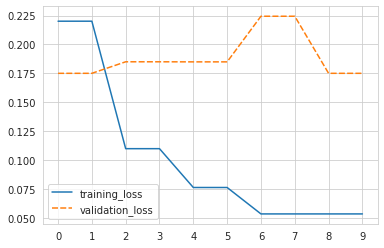

In [31]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = eval_df[['training_loss', 'validation_loss']])
ax.set_xticks(range(len(eval_df)), labels=range(len(eval_df)))
plt.show()

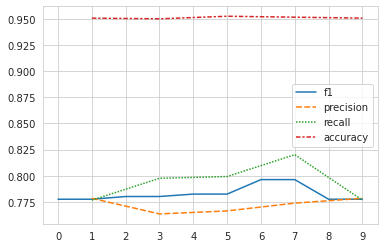

In [32]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = eval_df[['f1', 'precision', 'recall', 'accuracy']])
ax.set_xticks(range(len(eval_df)), labels=range(len(eval_df)))
plt.show()

In [33]:
trainer.create_model_card()

## Error Analysis

In [39]:
from torch.nn.functional import cross_entropy

In [48]:
num_labels = 13

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, num_labels), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [56]:
valid_set_new = eval_encoded
valid_set_new = valid_set_new.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set_new.to_pandas()

100%|█████████████████████████████████████████████| 9/9 [00:02<00:00,  4.19ba/s]


In [57]:
df.head()

input_ids  \
0  [0, 4815, 71478, 7, 211913, 152, 15, 10271, 13...   
1  [0, 19957, 33, 9026, 438, 867, 9136, 20, 46277...   
2  [0, 15603, 20, 124689, 7, 3370, 56077, 33, 157...   
3  [0, 67838, 43934, 121143, 429, 7797, 18917, 16...   
4  [0, 11213, 18190, 15539, 491, 706, 42144, 3121...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                              labels  \
0  [-100, 0, -100, -100, 0, 0, 0, 3, 0, 0, -100, ...   
1  [-100, 0, -100, 0, 0, -100, -100, 0, 0, -100, ...   
2  [-100, 0, 0, 0, -100, 0, 0, -100, 3, -100, 0, ...   
3  [-100, 0, -100, -100, -100, -100, -100, 5, 0, ...   
4  [-100, 5, -100, 0, 0, 0, -100, -100, -100, 0, ...   

                                                loss  \
0  [0.0, 0.0008012422, 0.0, 0.0, 0.00090415124, 0...   
1  [0.0, 0.00017975146, 0.0, 0.00017450718, 0.022...   
2  [0.0, 0.0009102254, 0.00031740396, 0.000481489...   
3  [0.0, 0.010785618, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
4  [0.0, 0.012027715, 0.0, 0.00052688544, 0.00011...   

                                     predicted_label  
0  [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 2, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, ...  
4  [0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...

In [58]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

input_ids  \
0  [0, 4815, 71478, 7, 211913, 152, 15, 10271, 13...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                              labels  \
0  [IGN, O, IGN, IGN, O, O, O, B-LOC, O, O, IGN, ...   

                                                loss  \
0  [0.0, 0.0008012422, 0.0, 0.0, 0.00090415124, 0...   

                                     predicted_label  \
0  [O, O, O, O, O, O, O, B-LOC, O, O, O, O, O, B-...   

                                        input_tokens  
0  [<s>, ▁Son, stige, s, ▁Abschnitt, ▁:, ▁(, ▁Ber...

In [59]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

input_ids attention_mask labels  loss predicted_label input_tokens
0      4815              1      O   0.0               O         ▁Son
0    211913              1      O   0.0               O   ▁Abschnitt
0       152              1      O   0.0               O           ▁:
0        15              1      O   0.0               O           ▁(
0     10271              1  B-LOC   0.0           B-LOC      ▁Berlin
0      1388              1      O   0.0               O           ▁)
0     38580              1      O   0.0               O         ▁Gül

In [69]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

0       1      2      3      4      5      6      7      8  \
input_tokens       ▁      ▁-     ▁#     ▁:   ▁Uhr     ▁@   ▁Heb     ▁(    ▁St   
count           1240     340    110    260     64    150      5    111     11   
mean            0.13    0.38    0.5   0.18   0.68   0.24   6.42   0.26   2.61   
sum           155.74  130.24  54.71  46.29  43.67  35.74  32.12  29.06  28.67   

                  9  
input_tokens     ▁/  
count            92  
mean            0.3  
sum           27.83

### Observations
- whitespace token has highest total loss, not surprising since most common token in the list (count: 1240)
- tokens: - # : Uhr @ ( / are rarer, but have relatively high mean loss -> appear often together with named entities, are even sometimes part of them, that's why model mixes them up; probably need to revise annotations / annotation guide 
- Heb, St -> ???

In [61]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

0         1       2       3       4       5       6      7   \
labels  I-ACTION  B-ACTION   I-ORG  B-TIME  I-DATE   B-ORG   I-LOC  I-PER   
count          6        47     251      95     166     416     315    127   
mean        6.01      1.51    1.38    0.86    0.59    0.58    0.52   0.51   
sum        36.06     71.01  347.21   81.94   97.52  241.76  162.36  65.33   

           8       9       10      11       12  
labels  B-PER  I-TIME  B-DATE   B-LOC        O  
count     142      61     214     852    12862  
mean     0.51     0.5    0.34    0.28     0.09  
sum     72.96   30.64    71.8  236.72  1186.62

### Observations
- I-ACTION has highest loss, ua because very rare (only 6 occurences) -> need for more data
- same for B-ACTION
- B-TIME: also rather rare, maybe because timecodes were included in Telegram?
- I-ORG: ???
- lowest loss: O
- lowest loss labels: B-LOC, B-DATE, I-TIME, B-PER, I-PER

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

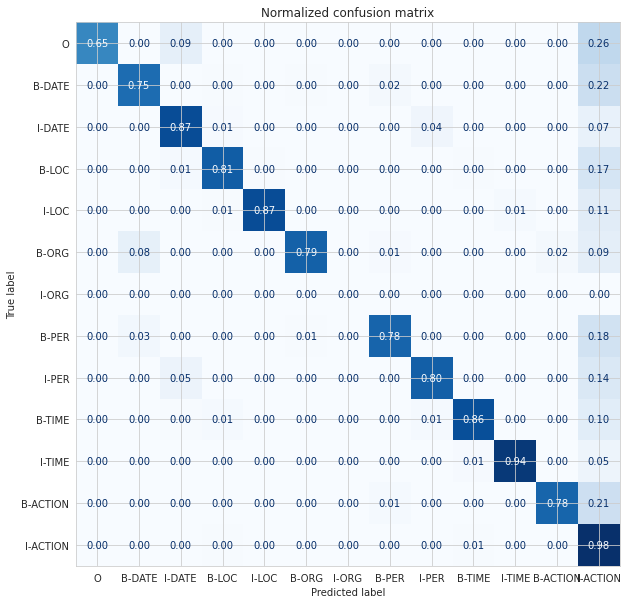

In [89]:
plot_confusion_matrix( df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

In [72]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

0      1      2      3         4      5     6     7     8    \
tokens   ▁POL     ▁-    ▁KN     ▁:  ▁Weitere  ▁Meld   ung  ▁für  ▁den   
labels  B-ORG  I-ORG  I-ORG  I-ORG         O      O   IGN     O     O   
preds       O      O      O      O         O      O     O     O     O   
losses   1.06   5.03   4.94   6.86      0.00   0.00  0.00  0.00  0.00   

               9    ...    501    502    503    504    505    506    507  \
tokens  ▁Landkreis  ...  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>   
labels       B-LOC  ...    IGN    IGN    IGN    IGN    IGN    IGN    IGN   
preds            O  ...      O      O      O      O      O      O      O   
losses        1.64  ...   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

          508    509    510  
tokens  <pad>  <pad>  <pad>  
labels    IGN    IGN    IGN  
preds       O      O      O  
losses   0.00   0.00   0.00  

[4 rows x 511 columns]

0      1      2      3      4     5        6       7       8    \
tokens  ▁Von   ▁Tor   sten   ▁Wei   gelt  ▁Die  ▁Kirche  ▁Sankt  ▁Peter   
labels     O  B-PER    IGN  I-PER    IGN     O        O       O       O   
preds      O  B-PER  B-PER  I-PER  I-PER     O        O   B-LOC   I-LOC   
losses  0.00   0.01   0.00   0.03   0.00  0.00     0.50    3.61    5.40   

          9    ...    501    502    503    504    505    506    507    508  \
tokens   ▁und  ...  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>   
labels      O  ...    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN   
preds   I-LOC  ...      O      O      O      O      O      O      O      O   
losses   4.90  ...   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

          509    510  
tokens  <pad>  <pad>  
labels    IGN    IGN  
preds       O      O  
losses   0.00   0.00  

[4 rows x 511 columns]

0     1      2     3     4     5     6     7     8     9    ...  \
tokens    ▁DJ     ▁  PRESS   EMI   TTE    IL   UNG    ▁/   ▁MY  NEWS  ...   
labels  B-ORG     O    IGN   IGN   IGN   IGN   IGN     O     O   IGN  ...   
preds       O     O      O     O     O     O     O     O     O     O  ...   
losses   3.70  0.00   0.00  0.00  0.00  0.00  0.00  0.00  0.04  0.00  ...   

          501    502    503    504    505    506    507    508    509    510  
tokens  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  
labels    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN  
preds       O      O      O      O      O      O      O      O      O      O  
losses   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  

[4 rows x 511 columns]

In [87]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head()
for sample in get_samples(df_tmp):
    display(sample)

0      1     2           3     4     5        6     7     8     9    \
tokens  ▁Son  stige     s  ▁Abschnitt    ▁:    ▁(  ▁Berlin    ▁)  ▁Gül   tig   
labels     O    IGN   IGN           O     O     O    B-LOC     O     O   IGN   
preds      O      O     O           O     O     O    B-LOC     O     O     O   
losses  0.00   0.00  0.00        0.00  0.00  0.00     0.00  0.00  0.00  0.00   

        ...    501    502    503    504    505    506    507    508    509  \
tokens  ...  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>   
labels  ...    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN   
preds   ...      O      O      O      O      O      O      O      O      O   
losses  ...   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

          510  
tokens  <pad>  
labels    IGN  
preds       O  
losses   0.00  

[4 rows x 511 columns]

0     1       2     3     4     5     6         7     8     9    ...  \
tokens  ▁Weg    en  ▁eines   ▁No   tar    tz    ▁-  ▁Einsatz    es  ▁ist  ...   
labels     O   IGN       O     O   IGN   IGN     O         O   IGN     O  ...   
preds      O     O       O     O     O     O     O         O     O     O  ...   
losses  0.00  0.00    0.00  0.02  0.00  0.00  0.00      0.00  0.00  0.00  ...   

          501    502    503    504    505    506    507    508    509    510  
tokens  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  
labels    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN  
preds       O      O      O      O      O      O      O      O      O      O  
losses   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  

[4 rows x 511 columns]

0     1      2     3     4      5      6       7      8     9    ...  \
tokens  ▁RSS    ▁-  ▁Feed     s   ▁Im   ▁Süd     en  ▁Japan      s  ▁hat  ...   
labels     O     O      O   IGN     O      O    IGN   B-LOC    IGN     O  ...   
preds      O     O      O     O     O  B-LOC  I-LOC   I-LOC  I-LOC     O  ...   
losses  0.00  0.00   0.00  0.00  0.00   3.31   0.00    5.13   0.00  0.00  ...   

          501    502    503    504    505    506    507    508    509    510  
tokens  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  
labels    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN  
preds       O      O      O      O      O      O      O      O      O      O  
losses   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  

[4 rows x 511 columns]

0     1       2     3     4       5      6      7     8      9    \
tokens  ▁Flug   beg  leiter    ge  werk  schaft   ▁UFO  ▁weit    et  ▁Stre   
labels      O   IGN     IGN   IGN   IGN     IGN  B-ORG      O   IGN      O   
preds       O     O       O     O     O       O  B-ORG      O     O      O   
losses   0.01  0.00    0.00  0.00  0.00    0.00   0.02   0.00  0.00   0.00   

        ...     501     502     503     504     505     506     507     508  \
tokens  ...   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   <pad>   
labels  ...     IGN     IGN     IGN     IGN     IGN     IGN     IGN     IGN   
preds   ...  I-TIME  I-TIME  I-TIME  I-TIME  I-TIME  I-TIME  I-TIME  I-TIME   
losses  ...    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

           509     510  
tokens   <pad>   <pad>  
labels     IGN     IGN  
preds   I-TIME  I-TIME  
losses    0.00    0.00  

[4 rows x 511 columns]

0      1       2     3     4     5     6     7        8     9    \
tokens   ▁Fan     uc  ▁kommt  ▁mit    ▁g   län   zen   den  ▁Zahlen  ▁zur   
labels  B-ORG    IGN       O     O     O   IGN   IGN   IGN        O     O   
preds   B-ORG  I-ORG       O     O     O     O     O     O        O     O   
losses   0.01   0.00    0.00  0.00  0.00  0.00  0.00  0.00     0.00  0.00   

        ...    501    502    503    504    505    506    507    508    509  \
tokens  ...  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>  <pad>   
labels  ...    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN   
preds   ...      O      O      O      O      O      O      O      O      O   
losses  ...   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

          510  
tokens  <pad>  
labels    IGN  
preds       O  
losses   0.00  

[4 rows x 511 columns]